***
# Name: Pratik Sayanekar | Student ID: 20200161
## COMP47650 Deep Learning Project
## Dataset -  B1: Twitter Sentiment Classification
***

<b>This notebook illustrates several data preprocessing strategies related to tweets.</b>

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of Contents</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#dataset" role="tab" aria-controls="profile">Loading Dataset<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#EDA" role="tab" aria-controls="messages">EDA of Twitter Dataset<span class="badge badge-primary badge-pill">2</span></a>    
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#preprocessing" role="tab" aria-controls="settings">Data Cleaning and Preprocessing<span class="badge badge-primary badge-pill">3</span></a>    
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#results" role="tab" aria-controls="settings">Preprocessing Results<span class="badge badge-primary badge-pill">4</span></a>     
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#save" role="tab" aria-controls="settings">Saving Preprocessed Data<span class="badge badge-primary badge-pill">5</span></a>

# Imports

In [1]:
!pip install tweet-preprocessor
!pip install gensim
!pip install textblob

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from collections import Counter, defaultdict
import string
from itertools import islice
import operator
import re
import preprocessor as p
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords

import textblob, string

/Users/pratiksayanekar/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pratiksayanekar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pratiksayanekar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pratiksayanekar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
import sys
filePath = '/Users/pratiksayanekar/Documents/DL_20200161'
#filePath = '/content/drive/My Drive/DeepLearning'
sys.path.append(filePath)

# <a id= 'dataset'>1. Loading Dataset</a>

In [5]:
df = pd.read_csv('{}/Data/dataset(clean).csv'.format(filePath))
df.head()

,Emotion,Content,Original Content
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat nsorry spot disappointedface,b'RT @Davbingodav: @mcrackins Oh fuck.... did I wrote Fil ??? :grinning_face_with_sweat:\nSorry Spot. :disappointed_face:'
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it
2,disappointed,i had been feeling a little bit defeated by the step of faith we would need to take to try to resolve our problem,i had been feeling a little bit defeated by the steps of faith we would need to take to try to resolve our problem
3,happy,imagine if that reaction guy that called jj kfc saw this my man would ve started cry lmao,"b""@KSIOlajidebt imagine if that reaction guy that called JJ KFC saw this. my man would've started crying lmao """
4,disappointed,i wouldnt feel burdened so that i would live my life a a testament to his sacrifice that wa out of a love so pure and innocent yet so great and mighty,i wouldnt feel burdened so that i would live my life as a testament to his sacrifice that was out of a love so pure and innocent yet so great and mighty


In [6]:
# rename column names
df.rename(columns={'Emotion':'emotion','Content':'content','Original Content':'original_content'}, inplace=True)
df.head()

,emotion,content,original_content
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat nsorry spot disappointedface,b'RT @Davbingodav: @mcrackins Oh fuck.... did I wrote Fil ??? :grinning_face_with_sweat:\nSorry Spot. :disappointed_face:'
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it
2,disappointed,i had been feeling a little bit defeated by the step of faith we would need to take to try to resolve our problem,i had been feeling a little bit defeated by the steps of faith we would need to take to try to resolve our problem
3,happy,imagine if that reaction guy that called jj kfc saw this my man would ve started cry lmao,"b""@KSIOlajidebt imagine if that reaction guy that called JJ KFC saw this. my man would've started crying lmao """
4,disappointed,i wouldnt feel burdened so that i would live my life a a testament to his sacrifice that wa out of a love so pure and innocent yet so great and mighty,i wouldnt feel burdened so that i would live my life as a testament to his sacrifice that was out of a love so pure and innocent yet so great and mighty


In [7]:
# shape of dataset
df.shape

(916575, 3)

In [8]:
# check any null values
df.isnull().sum()

emotion             0
content             0
original_content    0
dtype: int64

In [9]:
# check any na values
df.isna().sum()

emotion             0
content             0
original_content    0
dtype: int64

In [10]:
# target variable analysis
df.emotion.value_counts()

disappointed    313714
happy           301871
angry           300990
Name: emotion, dtype: int64

# <a id ='EDA'> EDA of Twitter Dataset </a>


**This is multiclass classification problem with categories as 'disappointed', 'happy' and 'angry'. The dataset is considerably balanced.**

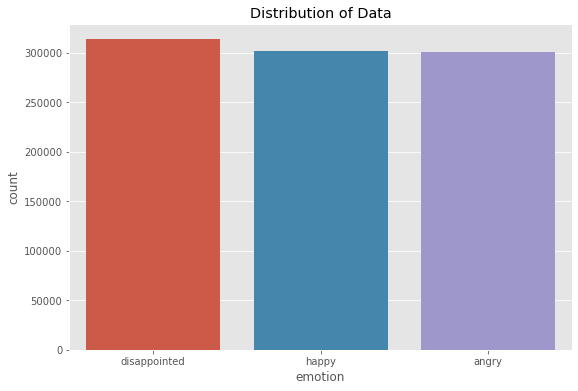

In [11]:
plt.figure(figsize=(9,6))
plt.title('Distribution of Data')
sns.countplot(x='emotion', data=df)
plt.savefig('{}/figs/Dataset/DataDistribution.png'.format(filePath))

**Before proceeding to the preprocessing of tweets let's explore textual features and patterns**

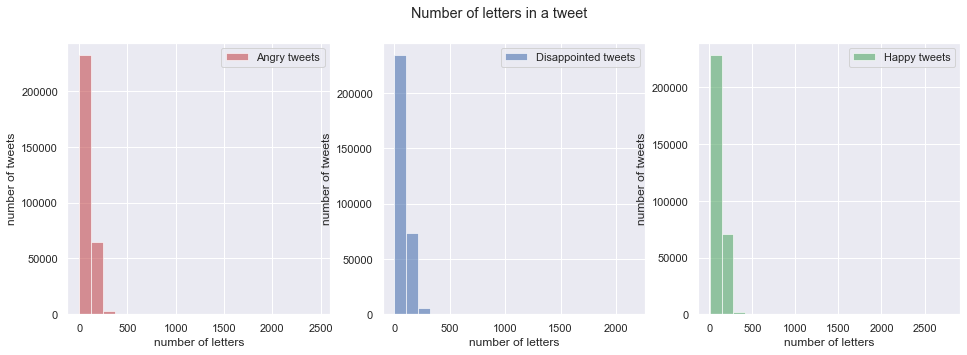

In [12]:
# Let's plot the number of letters in the disappointed, happy and angry tweets
sns.set()
fig = plt.figure(figsize = (16,5))

angry_len=df[df['emotion']=='angry']['original_content'].str.len() # extract the number of letters in the angry tweets
ax1 = fig.add_subplot(1,3,1)
ax1.hist(angry_len, alpha=0.6, bins=20, color='r',label = 'Angry tweets')
ax1.legend()

disappointed_len=df[df['emotion']=='disappointed']['original_content'].str.len() # extract the number of letters in the disappointed tweets
ax2 = fig.add_subplot(1,3,2)
ax2.hist(disappointed_len, alpha=0.6, bins=20,color='b',label = 'Disappointed tweets')
ax2.legend()

happy_len=df[df['emotion']=='happy']['original_content'].str.len() # extract the number of letters in the happy tweets
ax3 = fig.add_subplot(1,3,3)
ax3.hist(happy_len, alpha=0.6, bins=20,color='g',label = 'Happy tweets')
ax3.legend()

ax1.set_xlabel('number of letters')
ax1.set_ylabel('number of tweets')
ax2.set_xlabel('number of letters')
ax2.set_ylabel('number of tweets')
ax3.set_xlabel('number of letters')
ax3.set_ylabel('number of tweets')

fig.suptitle('Number of letters in a tweet')
fig.savefig('{}/figs/Dataset/NumberOfLetters.png'.format(filePath))

<b> Insights: <br>
    Maximum number of letters in each tweet is less than 400 and majority of tweets contains 100 to 150 letters.
    All categories shows similar trend.
</b>

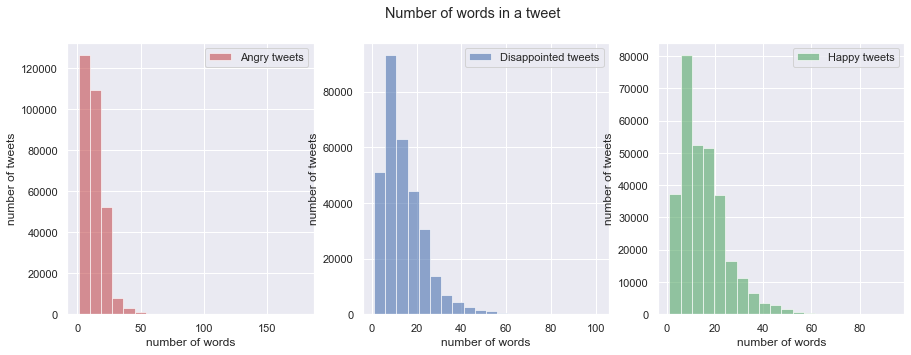

In [13]:
# Let's plot the number of words in the disappointed, happy and angry tweets
sns.set()
fig = plt.figure(figsize = (15,5))

angry_len=df[df['emotion']=="angry"]['original_content'].str.split().apply(len) # extract the number of words in the angry tweets
ax1 = fig.add_subplot(1,3,1)
ax1.hist(angry_len, alpha=0.6, bins=20, color='r',label = 'Angry tweets')
ax1.legend()

disappointed_len=df[df['emotion']=="disappointed"]['original_content'].str.split().apply(len) # extract the number of words in the disappointed tweets
ax2 = fig.add_subplot(1,3,2)
ax2.hist(disappointed_len, alpha=0.6, bins=20,color='b',label = 'Disappointed tweets')
ax2.legend()

happy_len=df[df['emotion']=="happy"]['original_content'].str.split().apply(len) # extract the number of words in the positive tweets
ax3 = fig.add_subplot(1,3,3)
ax3.hist(happy_len, alpha=0.6, bins=20,color='g',label = 'Happy tweets')
ax3.legend()

ax1.set_xlabel('number of words')
ax1.set_ylabel('number of tweets')
ax2.set_xlabel('number of words')
ax2.set_ylabel('number of tweets')
ax3.set_xlabel('number of words')
ax3.set_ylabel('number of tweets')

fig.suptitle('Number of words in a tweet')
fig.savefig('{}/figs/Dataset/NumberOfWords.png'.format(filePath))

<b> Insights: <br>
    Maximum number of words in each tweet is less than 60 and majority of tweets contains 25 to 30 words.
    All categories shows similar trend.
</b>

In [14]:
# Create the function to make the corpus
def create_corpus(target, column):
    corpus=[]
    for x in df[df['emotion']==target][column].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus_angry = create_corpus('angry', 'original_content') # corpus for the angry tweets
corpus_disappointed = create_corpus('disappointed', 'original_content') # corpus for the disappointed tweets
corpus_happy = create_corpus('happy', 'original_content') # corpus for the happy tweets

print('Length of angry corpus is', len(corpus_angry))
print('Length of disappointed corpus is', len(corpus_disappointed))
print('Length of happy corpus is', len(corpus_happy))

Length of angry corpus is 3863350
Length of disappointed corpus is 4300365
Length of happy corpus is 4560673


# **Most common words in each type of tweets**

In [15]:
# Let's create the function to extract the most common 30 words from the corpus 
def common_word(corpus):
    for idx, low in enumerate(corpus):
        corpus[idx] = low.lower()
    counter = Counter(corpus)
    stop_word_dict = {}
    for i in range(1,31):
        for stop in counter.most_common(i):
            stop_key = str(stop[0])
            stop_value = stop[1]
            stop_word_dict[stop_key] = stop_value
    return stop_word_dict

In [16]:
def Top_Words(corpus,fileName ):
    common = common_word(corpus)
    common_sorted = sorted(common.items(), key=lambda x:x[1], reverse=True)
    
    # Let's show the words and how many did they appear in the angry tweets
    
    word_count_list, common_word_list = [], []
    for word_count in common_sorted:
        common_word_list.append(word_count[0])
        word_count_list.append(word_count[1])
    
    plt.figure(figsize=(15,8))
    plt.title('Top 30 words appeared the most in the {}'.format(fileName))
    plt.xlabel('top 30 words')
    plt.xticks(rotation='vertical')
    plt.ylabel('count')
    plt.bar(common_word_list, word_count_list, alpha=0.6, color='r')
    fig.savefig('{}/figs/Dataset/Top30Words_{}.png'.format(filePath,fileName))

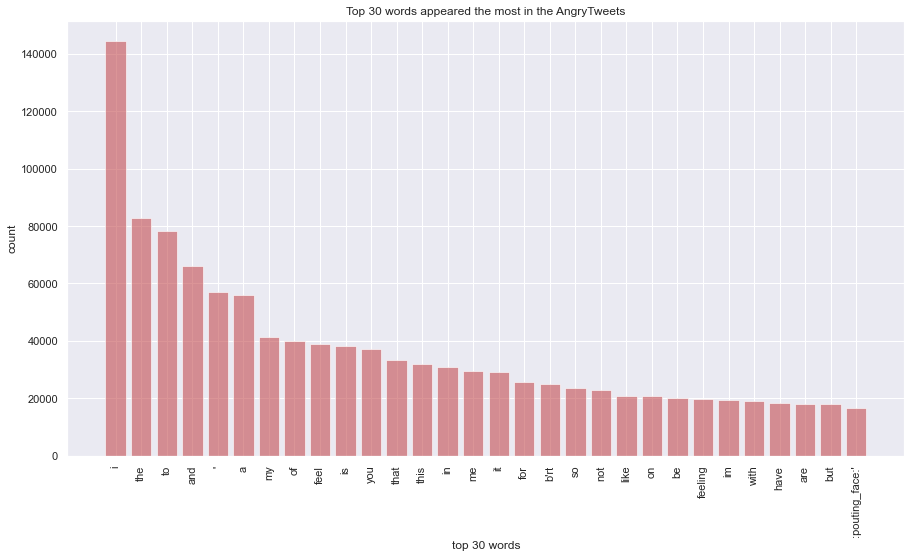

In [17]:
Top_Words(corpus_angry,'AngryTweets')

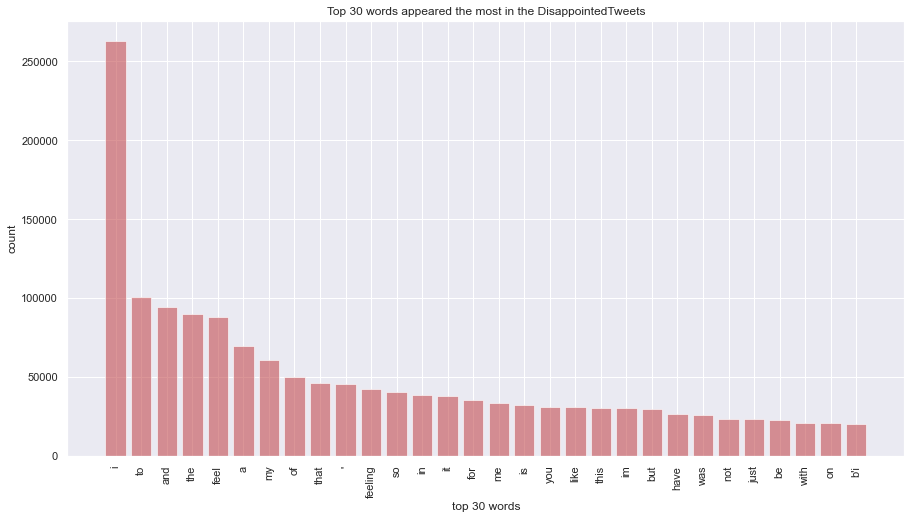

In [18]:
Top_Words(corpus_disappointed,'DisappointedTweets')

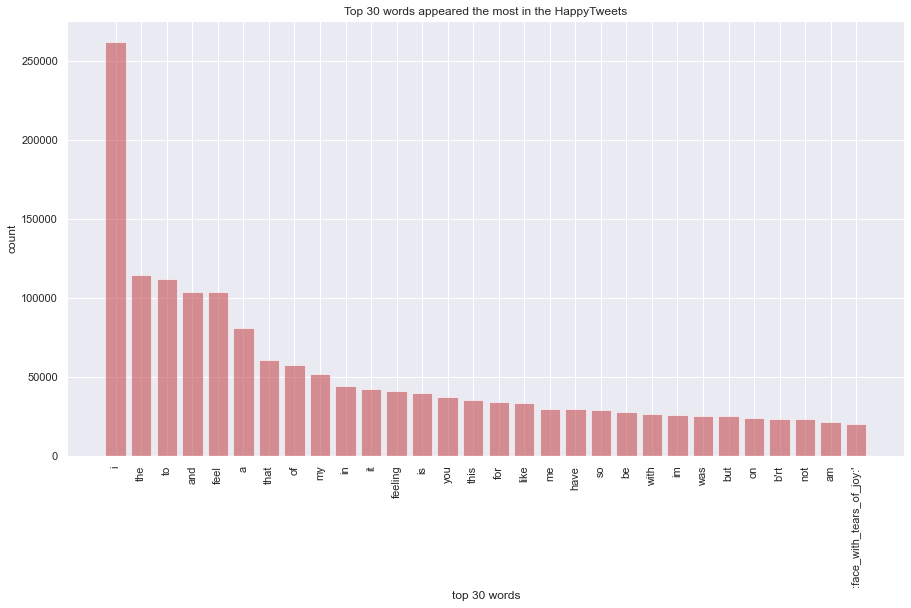

In [19]:
Top_Words(corpus_happy,'HappyTweets')


**As we can see the most used words in each category of tweets are almost similar. We can infer that we need to remove all of such stop words to make the classifier efficient.**

# **Most common Punctuations in each category of tweets**

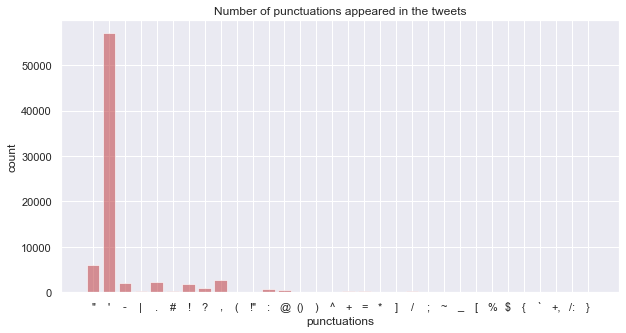

In [20]:
def punctuation_show(corpus, color, name):
    plt.figure(figsize=(10,5))
    plt.title('Number of punctuations appeared in the tweets')
    plt.xlabel('punctuations')
    plt.ylabel('count')
    punc_dict = defaultdict(int)
    punc = string.punctuation
    for i in corpus:
        if i in punc:
            punc_dict[i] += 1
    punc_key = punc_dict.keys()
    punc_value = punc_dict.values()
    plt.bar(punc_key, punc_value, alpha=0.6, color=color)
    plt.savefig('{}/figs/Dataset/{}.png'.format(filePath,name))

punctuation_show(corpus_angry, 'r', 'TopPunctuationsAngryTweets') # This shows the result of angry tweets

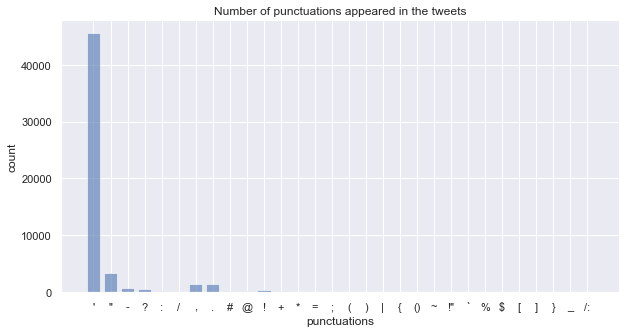

In [21]:
punctuation_show(corpus_disappointed, 'b','TopPunctuationsDisappointedTweets')

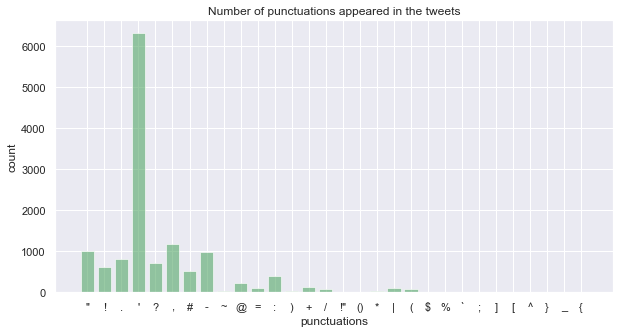

In [22]:
punctuation_show(corpus_happy, 'g','TopPunctuationsHappyTweets')

**As we can see among all punctuations single quote is majorly used in all tweets and no punctuation distinctly classifiy the tweet so we can infer that punctuations should be removed to make the classification more efficient.** 

In [23]:
def emoticons_show(corpus, color, name):
    punc_dict = defaultdict(int)
    for i in corpus:
        if i[0]==':' and i[-1]==':' and len(i)>4:
            punc_dict[i] += 1
    sorted_dict = dict(sorted(punc_dict.items(), key=operator.itemgetter(1),reverse=True))
    sorted_dict = dict(list(islice(sorted_dict.items(), 10)))
    plt.figure(figsize=(10,5))
    plt.title('Number of emojis appeared in the tweets')
    plt.xlabel('emojis')
    plt.ylabel('count')
    plt.xticks(rotation='vertical')
    plt.bar(sorted_dict.keys(), sorted_dict.values(), alpha=0.6, color=color)
    plt.savefig('{}/figs/Dataset/{}.png'.format(filePath, name))

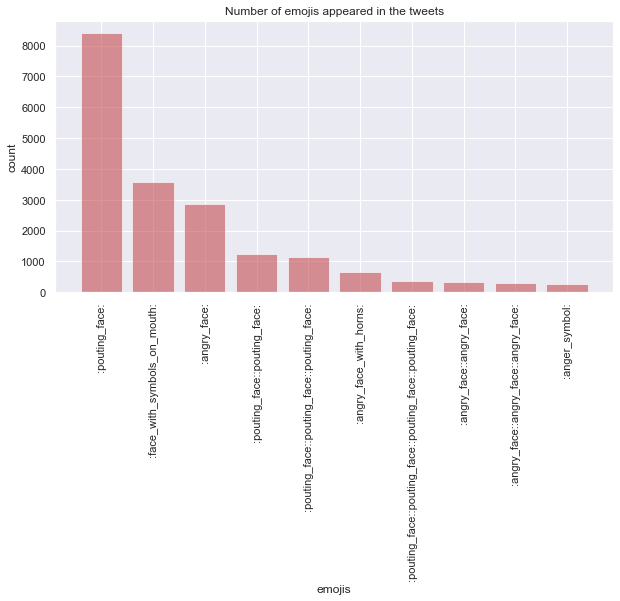

In [24]:
# Number of emojis appeared in Angry Tweets
emoticons_show(corpus_angry, 'r', 'TopEmojisAngryTweets')

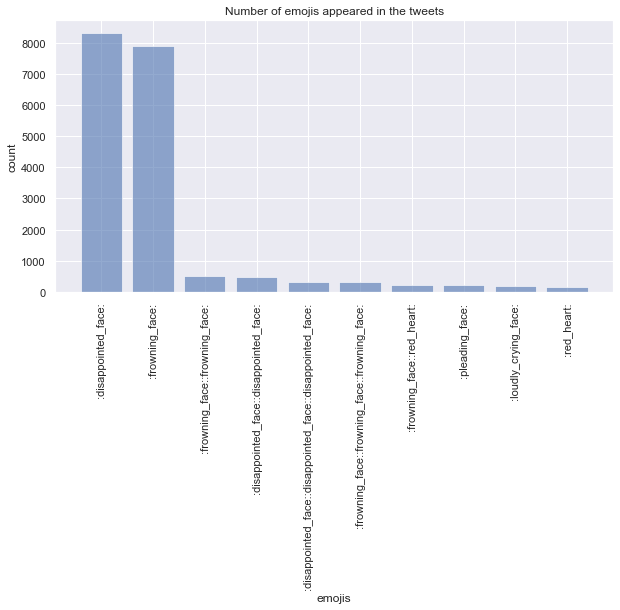

In [25]:
# Number of emojis appeared in Disappointed Tweets
emoticons_show(corpus_disappointed, 'b', 'TopEmojisDisappointedTweets')

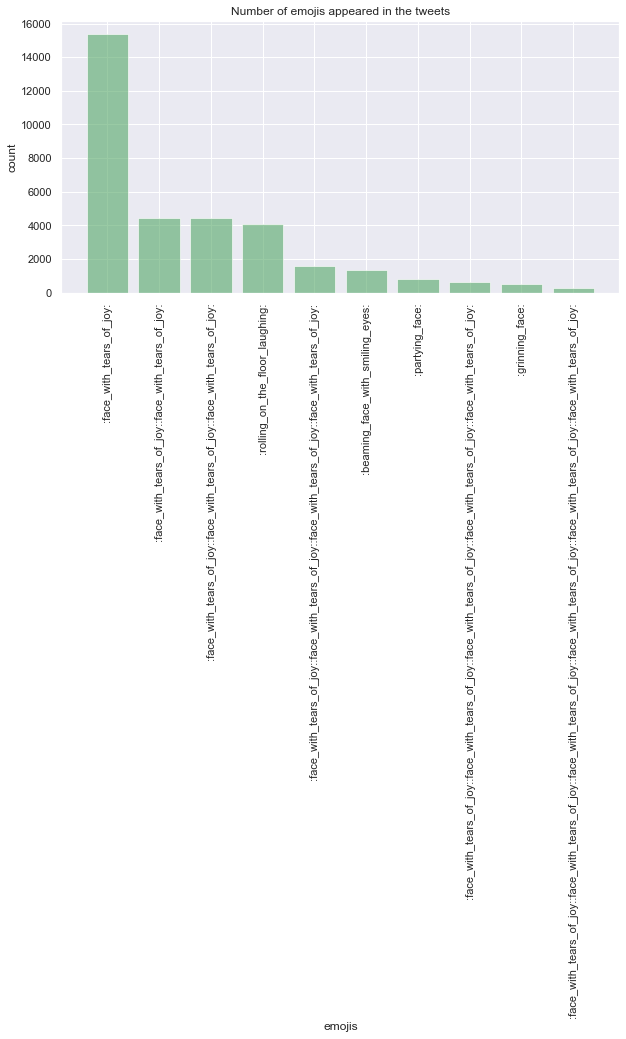

In [26]:
# Number of emojis appeared in Happy Tweets
emoticons_show(corpus_happy, 'g', 'TopEmojishappyTweets')

**We can infer that emojis are vital in categorising the tweets as the majority of emojis in each type of tweets are distinct. So we should take the emoji in consideration to make the classification efficient.**

# <a id='preprocessing'> Data Cleaning and Preprocessing </a>

**Here, we are preprocessing the original_text data and maintaining a new column as text of preprocessed and cleaned textual data.**

In inital phase of this project, I was doing text preprocessing manually using regular expression and string utility function, But in later stage, I came accross few APIs that are specifically designed for tweet preprocessing. After analysing the result of both preprocessing techniques, I decided to proceed further with more efficient code.

In [27]:
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')


# # Remove URL
# url = re.compile(r'https?://\S+|www\.\S+')
# df['text'] = df['text'].apply((lambda x: url.sub(r'',x)))
# # Remove HTML
# html = re.compile(r'<.*?>')
# df['text'] = df['text'].apply(lambda x: html.sub(r'',x))
# # Remove the words which contain the number
# df['text'] = df['text'].apply(lambda x: re.sub('\w*\d\w*', '', x))

# # Remove the words which contains @ character
# df['text'] = df['text'].apply(lambda x: re.sub('\w*\"@\w*', '', x))
# df['text'] = df['text'].apply(lambda x: re.sub('\w*\'@\w*', '', x))
# df['text'] = df['text'].apply(lambda x: re.sub('\w*@\w*', '', x))

# # removing emoticons
# df['text'] = df['text'].apply(lambda x: re.sub(':\w*:', '', x))

# #removing RT
# df['text'] = df['text'].apply(lambda x: re.sub('\w*\'RT[\s]+', '', x))

# # Remove stop words
# # df['text'] = f['text'].apply(lambda x: [item for item in x if item not in stopwords.words('english')])


# df['text'] = df['text'].apply(lambda x: re.sub(' +', ' ', x))

# df['text'] = df['text'].apply(lambda x: x.strip())
# # Make the tweet lower letters
# df['text'] = df['text'].apply(lambda x: x.lower())
# # Remove punctuation 
# table = str.maketrans('','',string.punctuation)
# df['text'] = df['text'].apply((lambda x: x.translate(table)))

In [28]:
# method to preprocess tweets using tweet-preprocessor API
def preprocess_tweet(data):
    text = data['original_content']
    text = p.clean(text)
    return text

# method to remove stopwords using gensim
def stopword_removal(data):
    text = data['text']
    text = remove_stopwords(text)
    return text

# method to remove single letter words
def remove_single_letter_words(data):
    words = data.text.split()
    reformed = []
    for w in words:
        if len(w) > 1:
            reformed.append(w)
    t = " ".join(reformed)
    return t


df['text'] = df.apply(preprocess_tweet, axis=1)

# Lemmatization for verbs and nouns
# lemmat = WordNetLemmatizer()
# df['text'] = df['text'].apply(lambda x: " ".join([lemmat.lemmatize(word,'v') for word in x.split()]))
# df['text'] = df['text'].apply(lambda x: " ".join([lemmat.lemmatize(word,'n') for word in x.split()]))

#removing punctuations except '_' as this is vital to identify emojis
df['text'] = df['text'].apply(lambda x: re.sub('[!"$%&\'()*+,-./:@;<=>?[\\]^`{|}~]', ' ', x))

#replacing unnecessary spaces and converting all words to lowercase
df['text'] = df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

# removing irrelevant words 'rt'
df['text'] = df['text'].apply(lambda x: re.sub(r'\b(rt|im)\b','',x).strip())

# Stop word removal
df['text'] = df.apply(stopword_removal, axis=1)

# Single letter word removal
df['text'] = df.apply(remove_single_letter_words, axis=1)

# <a id='results'> Preprocessing Results </a>

In [29]:
df.head()

,emotion,content,original_content,text
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat nsorry spot disappointedface,b'RT @Davbingodav: @mcrackins Oh fuck.... did I wrote Fil ??? :grinning_face_with_sweat:\nSorry Spot. :disappointed_face:',oh fuck wrote fil grinning_face_with_sweatnsorry spot isappointed_face
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it,feel shamed
2,disappointed,i had been feeling a little bit defeated by the step of faith we would need to take to try to resolve our problem,i had been feeling a little bit defeated by the steps of faith we would need to take to try to resolve our problem,feeling little bit defeated steps faith need try resolve problem
3,happy,imagine if that reaction guy that called jj kfc saw this my man would ve started cry lmao,"b""@KSIOlajidebt imagine if that reaction guy that called JJ KFC saw this. my man would've started crying lmao """,imagine reaction guy called jj kfc saw man ve started crying lmao
4,disappointed,i wouldnt feel burdened so that i would live my life a a testament to his sacrifice that wa out of a love so pure and innocent yet so great and mighty,i wouldnt feel burdened so that i would live my life as a testament to his sacrifice that was out of a love so pure and innocent yet so great and mighty,wouldnt feel burdened live life testament sacrifice love pure innocent great mighty


In [30]:
preprocessed_corpus_angry = create_corpus('angry', 'text') # corpus for the angry tweets
preprocessed_corpus_disappointed = create_corpus('disappointed', 'text') # corpus for the disappointed tweets
preprocessed_corpus_happy = create_corpus('happy', 'text') # corpus for the happy tweets

print('Length of angry corpus after preprocessing is:', len(preprocessed_corpus_angry))
print('Length of disappointed corpus after preprocessing is:', len(preprocessed_corpus_disappointed))
print('Length of happy corpus after preprocessing is:', len(preprocessed_corpus_happy))

Length of angry corpus after preprocessing is: 1829255
Length of disappointed corpus after preprocessing is: 1926536
Length of happy corpus after preprocessing is: 2181548


<b>Preprocessing Insights: <br>
<li> After preprocessing, we have successfully removed all unnecessary words. This shows significant depletion in the length of Angry, Disappointed and Happy corpus.</li>
<li> Angry corpus depleted from 38,63,350 to 18,80,256.</li>
<li> Disappointed corpus depleted from 43,00,365 to 19,78,341.</li>
<li> Angry corpus depleted from 45,60,673 to 22,35,776.</li>
<li> These numbers shows that preprocessing help us removing more than 50% unnecessary words.</li>
</b>

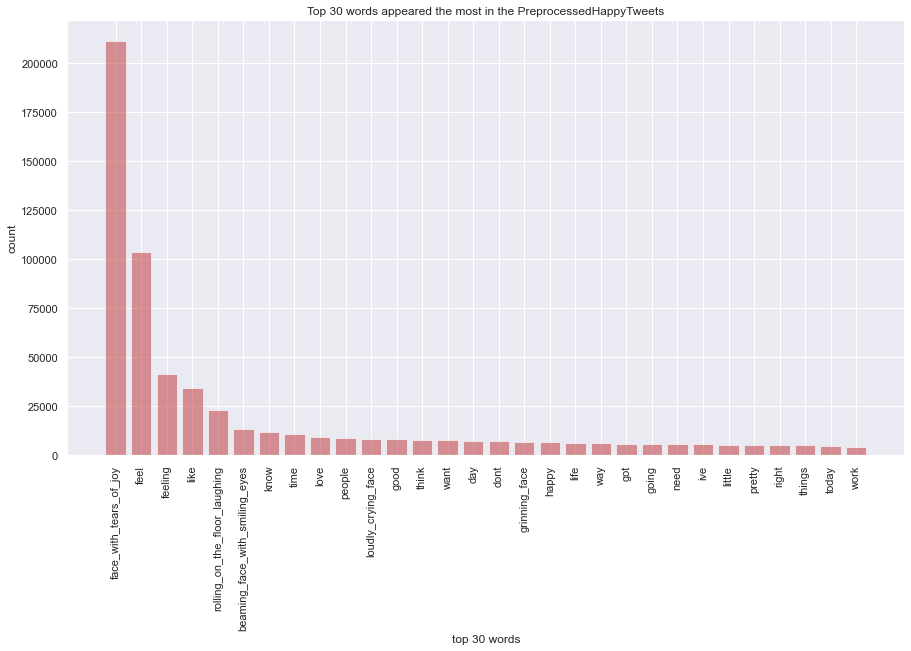

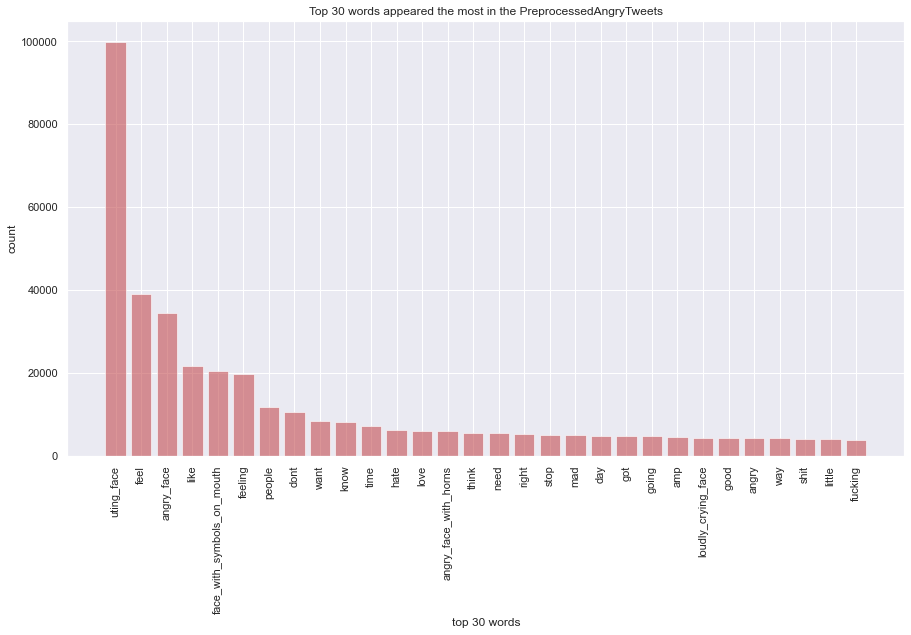

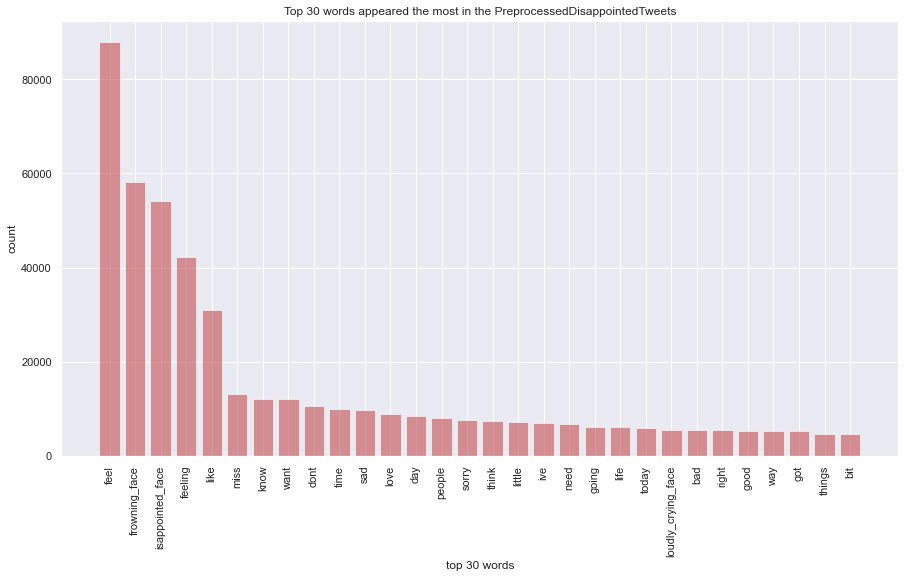

In [31]:
Top_Words(preprocessed_corpus_happy,'PreprocessedHappyTweets')
Top_Words(preprocessed_corpus_angry,'PreprocessedAngryTweets')
Top_Words(preprocessed_corpus_disappointed,'PreprocessedDisappointedTweets')

### Text based features and NLP Features 

<b>There are some textual features that we can monitor as a part of data preprocessing stage. These features directs the further cleaning approach and modeling approach. They are as follows,

<li>Number of characters</li>
<li>Number of words</li>
<li>Character to word ratio</li>
<li>Number of punctuations</li>
<li>Number of Title words</li>    
<li>Number of Upper case words</li>
    
</b>

In [32]:
def generate_text_features(df):
    df['char_count'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['word_density'] = df['char_count'] / (df['word_count']+1)
    df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
    df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [33]:
generate_text_features(df)

<b>In NLP, POS tagging i.e. Part of speech tagging where number of nouns, pronouns, verb, adjectives and adverb are extracted from the corpus. We can monitor these attributes to decide further preprocessing strategy.</b>

In [34]:
# function to check and get the part of speech tag count of a words in a given sentence
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                #print(tup)
                cnt += 1
    except:
        pass
    return cnt


def generate_NLP_features(df):
    df['noun_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'noun'))
    print('noun_count generated..')
    df['verb_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'verb'))
    print('verb_count generated..')
    df['adj_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'adj'))
    print('adj_count generated..')
    df['adv_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'adv'))
    print('adv_count generated..')
    df['pron_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'pron'))
    print('pron_count generated..')

In [35]:
generate_NLP_features(df) # this may take time to execute...

noun_count generated..
verb_count generated..
adj_count generated..
adv_count generated..
pron_count generated..


In [36]:
df.head()

,emotion,content,original_content,text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat nsorry spot disappointedface,b'RT @Davbingodav: @mcrackins Oh fuck.... did I wrote Fil ??? :grinning_face_with_sweat:\nSorry Spot. :disappointed_face:',oh fuck wrote fil grinning_face_with_sweatnsorry spot isappointed_face,70,7,8.750000,4,0,0,3,1,2,0,0
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it,feel shamed,11,2,3.666667,0,0,0,1,1,0,0,0
2,disappointed,i had been feeling a little bit defeated by the step of faith we would need to take to try to resolve our problem,i had been feeling a little bit defeated by the steps of faith we would need to take to try to resolve our problem,feeling little bit defeated steps faith need try resolve problem,64,10,5.818182,0,0,0,3,4,3,0,0
3,happy,imagine if that reaction guy that called jj kfc saw this my man would ve started cry lmao,"b""@KSIOlajidebt imagine if that reaction guy that called JJ KFC saw this. my man would've started crying lmao """,imagine reaction guy called jj kfc saw man ve started crying lmao,65,12,5.000000,0,0,0,7,4,1,0,0
4,disappointed,i wouldnt feel burdened so that i would live my life a a testament to his sacrifice that wa out of a love so pure and innocent yet so great and mighty,i wouldnt feel burdened so that i would live my life as a testament to his sacrifice that was out of a love so pure and innocent yet so great and mighty,wouldnt feel burdened live life testament sacrifice love pure innocent great mighty,83,12,6.384615,0,0,0,8,1,3,0,0


In [37]:
df.tail()

,emotion,content,original_content,text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
916570,happy,lmaoo facewithtearsofjoy facewithtearsofjoy exactly none of you can fight me cause vele yall ca nt swim,"b""@babyboykagiso @pea__nut_ @on_taaa_tile @gosegomokgothuu @ole_smiley Lmaooo:face_with_tears_of_joy::face_with_tears_of_joy: Exactly none of you can fight me cause vele yall can't swim""",lmaooo face_with_tears_of_joy face_with_tears_of_joy exactly fight cause vele yall swim,87,9,8.700000,8,0,0,6,1,0,2,0
916571,disappointed,last day for this peony rain on it way colder weather a well coldface frowningface,b'Last day for this peony rain on its way. Colder weather as well. :cold_face::frowning_face: https://t.co/TizSCEO2NU',day peony rain way colder weather cold_face frowning_face,57,8,6.333333,2,0,0,8,0,0,0,0
916572,happy,no bird rollingonthefloorlaughing,b'@lynda_lambert @DorsetWildlife No birds :rolling_on_the_floor_laughing:',birds rolling_on_the_floor_laughing,35,2,11.666667,4,0,0,1,1,0,0,0
916573,angry,man i had to cancel trip so far this year covid need to end mane facewithsymbolsonmouth,"b'Man I had to cancel 2 trips so far this year, COVID need to end mane.. :face_with_symbols_on_mouth:'",man cancel trips far year covid need end mane face_with_symbols_on_mouth,72,10,6.545455,4,0,0,6,3,0,1,0
916574,happy,im really so thankful for this one week break before the accounting paper finally managed to catch up on sleep a little and i feel a lot more relaxed,im really so thankful for this one week break before the accounting paper finally managed to catch up on sleep a little and i feel a lot more relaxed,thankful week break accounting paper finally managed catch sleep little feel lot relaxed,88,13,6.285714,0,0,0,8,2,2,1,0


In [38]:
df.describe()

,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
count,916575.000000,916575.000000,916575.000000,916575.000000,916575.0,916575.0,916575.000000,916575.000000,916575.000000,916575.000000,916575.000000
mean,51.575327,6.477745,6.504915,1.962993,0.0,0.0,3.438234,1.375040,1.212132,0.285526,0.005623
std,46.655111,4.413159,2.601708,5.356861,0.0,0.0,2.635957,1.365809,1.338809,0.577814,0.076507
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,3.000000,5.000000,0.000000,0.0,0.0,2.000000,0.000000,0.000000,0.000000,0.000000
50%,43.000000,6.000000,6.000000,0.000000,0.0,0.0,3.000000,1.000000,1.000000,0.000000,0.000000
75%,67.000000,9.000000,7.333333,2.000000,0.0,0.0,5.000000,2.000000,2.000000,0.000000,0.000000
max,2640.000000,121.000000,42.500000,412.000000,0.0,0.0,119.000000,43.000000,69.000000,9.000000,4.000000


<b> Insights:<br>
    <li>As we can see the maximum word count is 122, So we will use this count while nueral modeling for tokenization and padding. </li>
    <li>After preprocessing, we are able to remove title word(First letter Capital), upper case word and punctuations </li>
    <li>The punctuation count 412 is nothing but '_' punctuation, we have maintained it to differentiate emojis as all emoji's contain '_' char in them, we can use this in nueral modeling.</li>
    
</b>

# <a id='save'>Saving Preprocessed data</a>

In [39]:
df = df[['emotion', 'text']]
df.head()

,emotion,text
0,disappointed,oh fuck wrote fil grinning_face_with_sweatnsorry spot isappointed_face
1,disappointed,feel shamed
2,disappointed,feeling little bit defeated steps faith need try resolve problem
3,happy,imagine reaction guy called jj kfc saw man ve started crying lmao
4,disappointed,wouldnt feel burdened live life testament sacrifice love pure innocent great mighty


In [40]:
df.to_csv('{}/Data/preprocessed_data.csv'.format(filePath), index = False)